# 🛒 Retail/E-commerce Recommendation System (Fully Implemented with Visualizations)

- **Complete Data Integration**: Uses `events`, `item_properties`, and `category_tree` data.
- **Visualizations**: Includes comparisons for before/after data processing and hyperparameter tuning.
- **Models**: Most Popular, SVD (Collaborative), and a powerful **Hybrid GRU4Rec Model**.
- **Full Evaluation & Demo**: Compares all models to showcase the benefits of the hybrid approach.

In [ ]:
# Install necessary libraries if they are not already installed
# !pip install pandas numpy scikit-learn torch matplotlib scikit-surprise

## 1. Data Loading & Initial Statistics

--- Initial Raw Data Statistics ---


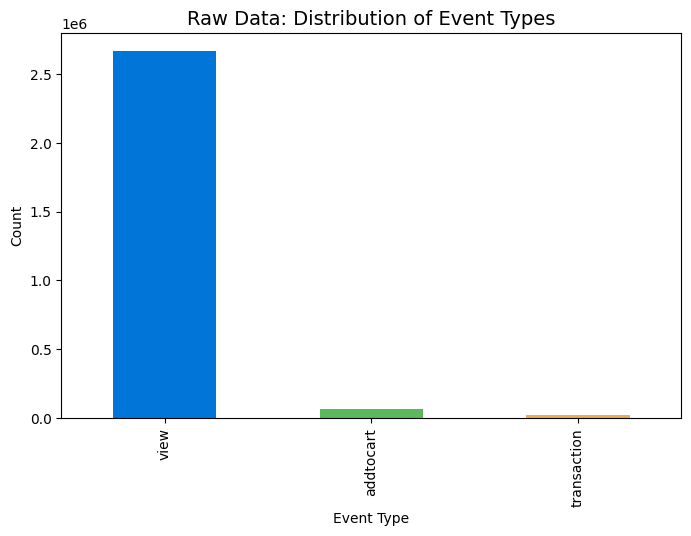

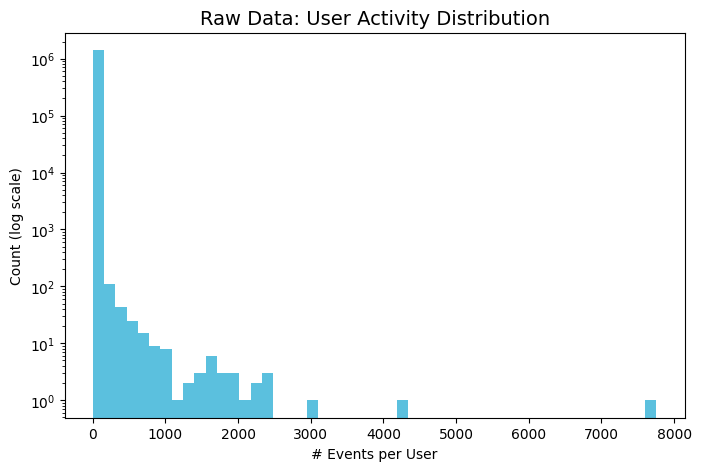

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import defaultdict

print("--- Loading all data sources ---")
events = pd.read_csv('events.csv')
category_tree = pd.read_csv('category_tree.csv') 
item_properties_1 = pd.read_csv('item_properties_part1.csv')
item_properties_2 = pd.read_csv('item_properties_part2.csv')
item_properties = pd.concat([item_properties_1, item_properties_2], ignore_index=True)

# Store raw data stats for later comparison
raw_events_stats = {
    'total_events': events.shape[0],
    'unique_users': events['visitorid'].nunique(),
    'unique_items': events['itemid'].nunique()
}

# Function to plot a bar chart for event types
def plot_event_type_bar(df, title):
    plt.figure(figsize=(8,5))
    df['event'].value_counts().plot(kind='bar', color=['#0275d8','#5cb85c','#f0ad4e'])
    plt.title(title, fontsize=14)
    plt.xlabel("Event Type")
    plt.ylabel("Count")
    plt.show()

# Function to plot a histogram by group
def plot_hist_by_group(df, group_col, title, xlabel, color):
    plt.figure(figsize=(8,5))
    df.groupby(group_col).size().plot(kind='hist', bins=50, log=True, color=color)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Count (log scale)")
    plt.show()

print("--- Initial Raw Data Statistics ---")
plot_event_type_bar(events, "Raw Data: Distribution of Event Types")
plot_hist_by_group(events, 'visitorid', "Raw Data: User Activity Distribution", "# Events per User", '#5bc0de')

## 2. Data Preprocessing & Merging

In [3]:
print("--- Processing item properties to extract categories ---")
item_properties['datetime'] = pd.to_datetime(item_properties['timestamp'], unit='ms')
item_categories = item_properties[item_properties['property'] == 'categoryid'].copy()
item_categories = item_categories.sort_values('datetime', ascending=False)
item_categories = item_categories.drop_duplicates(subset='itemid', keep='first')
item_categories = item_categories[['itemid', 'value']].rename(columns={'value': 'categoryid'})
item_categories['categoryid'] = item_categories['categoryid'].astype(int)
print("Item category processing complete.")

print("--- Cleaning event data ---")
events = events.drop_duplicates().copy()
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')

user_hour = events.groupby(['visitorid', pd.Grouper(key='datetime', freq='h')]).size().reset_index(name='event_count')
bots = user_hour[user_hour['event_count'] > 200]['visitorid'].unique()
events = events[~events['visitorid'].isin(bots)]

active_users = events['visitorid'].value_counts()[lambda x: x >= 5].index
active_items = events['itemid'].value_counts()[lambda x: x >= 5].index
events = events[events['visitorid'].isin(active_users) & events['itemid'].isin(active_items)].copy()
print("Event data cleaning complete.")

print("--- Merging all data sources ---")
events_merged = events.merge(item_categories, on='itemid', how='left')
events_merged.loc[:, 'categoryid'] = events_merged['categoryid'].fillna(-1)
events_merged['categoryid'] = events_merged['categoryid'].astype(int)
print("Merging complete.")

--- Processing item properties to extract categories ---
Item category processing complete.
--- Cleaning event data ---
Event data cleaning complete.
--- Merging all data sources ---
Merging complete.


### 2a. Visualizing the Impact of Preprocessing

--- Data Comparison Table ---


,total_events,unique_users,unique_items
Before Processing,2756101,1407580,235061
After Processing,895965,81287,67541



--- User Activity Distribution Comparison ---


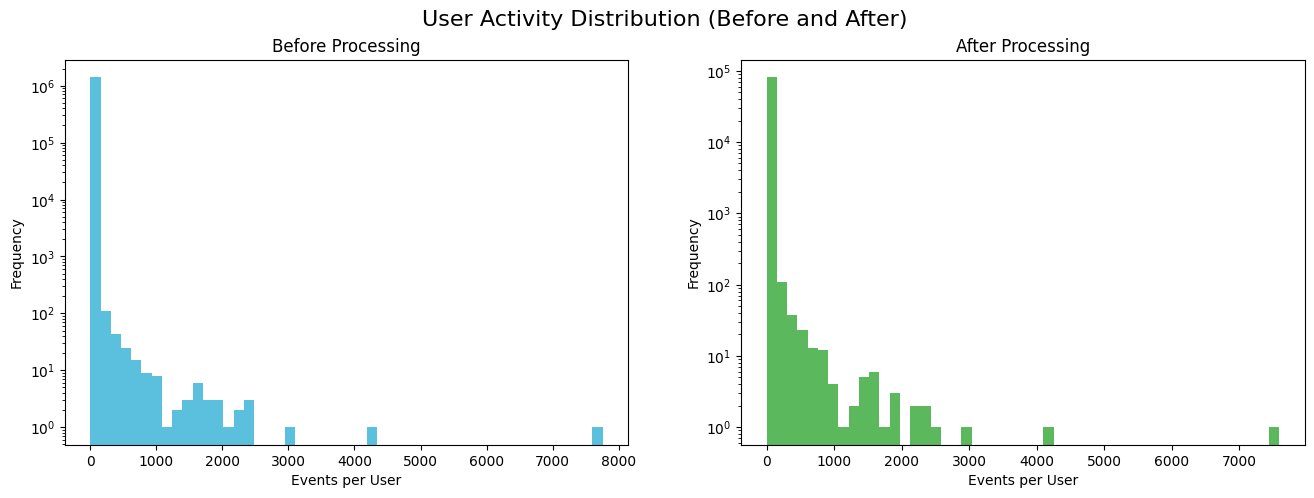

In [4]:
# --- Comparing key metrics before and after cleaning ---
cleaned_events_stats = {
    'total_events': events_merged.shape[0],
    'unique_users': events_merged['visitorid'].nunique(),
    'unique_items': events_merged['itemid'].nunique()
}

comparison_df = pd.DataFrame([raw_events_stats, cleaned_events_stats], index=['Before Processing', 'After Processing'])
print("--- Data Comparison Table ---")
display(comparison_df)

# --- Distribution Comparison Plots ---
raw_events_df = pd.read_csv('events.csv')

print("\n--- User Activity Distribution Comparison ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
raw_events_df.groupby('visitorid').size().plot(kind='hist', bins=50, log=True, ax=axes[0], color='#5bc0de', title='Before Processing')
events_merged.groupby('visitorid').size().plot(kind='hist', bins=50, log=True, ax=axes[1], color='#5cb85c', title='After Processing')
axes[0].set_xlabel('Events per User')
axes[1].set_xlabel('Events per User')
plt.suptitle('User Activity Distribution (Before and After)', fontsize=16)
plt.show()

## 3. Feature Engineering (Enhanced)

In [5]:
print("--- Starting feature engineering ---")
df = events_merged.copy()

df = df.sort_values(['visitorid', 'datetime'])
df['session_id_num'] = (df.groupby('visitorid')['datetime'].diff().gt(timedelta(minutes=30))).cumsum().astype(int)
df['session_id'] = df['visitorid'].astype(str) + '_' + df['session_id_num'].astype(str)

event_map = {'view': 1, 'addtocart': 3, 'transaction': 5}
df['event_weight'] = df['event'].map(event_map)

user_enc = LabelEncoder()
item_enc = LabelEncoder()
cat_enc = LabelEncoder()
df['user_idx'] = user_enc.fit_transform(df['visitorid'])
df['item_idx'] = item_enc.fit_transform(df['itemid'])
df['category_idx'] = cat_enc.fit_transform(df['categoryid'])

print("Feature engineering complete.")

--- Starting feature engineering ---
Feature engineering complete.


## 4. Data Split (Temporal)

In [6]:
max_date = df['datetime'].max()
train_cutoff = max_date - timedelta(weeks=2)
val_cutoff = max_date - timedelta(weeks=1)

train = df[df['datetime'] < train_cutoff]
valid = df[(df['datetime'] >= train_cutoff) & (df['datetime'] < val_cutoff)]
test = df[df['datetime'] >= val_cutoff]

## 5. Model Training

### Model 1: Most Popular (Baseline)

In [7]:
most_popular = train['item_idx'].value_counts().index[:20].tolist()

### Model 2: SVD Collaborative Filtering (Baseline)

In [8]:
from surprise import Dataset, Reader, SVD

svd_model = None
try:
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(train[['user_idx', 'item_idx', 'event_weight']], reader)
    trainset = data.build_full_trainset()
    svd_model = SVD(n_factors=50, n_epochs=20, random_state=42, verbose=True)
    svd_model.fit(trainset)
    print("--- SVD model training complete. ---")
except Exception as e:
    print(f"--- Could not train SVD model: {e} ---")
    svd_model = None

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--- SVD model training complete. ---


### Model 3: Hybrid GRU4Rec (Main Model)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class HybridSessionDataset(Dataset):
    def __init__(self, df, maxlen=10):
        self.df = df
        session_groups = df.groupby('session_id')
        self.sessions = [
            (group['item_idx'].tolist(), group['category_idx'].tolist())
            for name, group in session_groups
        ]
        
        self.samples = []
        for item_seq, cat_seq in self.sessions:
            for i in range(1, len(item_seq)):
                start = max(0, i - maxlen)
                self.samples.append(((item_seq[start:i], cat_seq[start:i]), item_seq[i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        (item_seq, cat_seq), label = self.samples[idx]
        item_x = np.zeros(10, dtype=int)
        cat_x = np.zeros(10, dtype=int)
        item_x[-len(item_seq):] = item_seq[-10:]
        cat_x[-len(cat_seq):] = cat_seq[-10:]
        return torch.LongTensor(item_x), torch.LongTensor(cat_x), torch.LongTensor([label])

class HybridGRU4Rec(nn.Module):
    def __init__(self, n_items, n_cats, item_emb_dim=50, cat_emb_dim=10, hid_dim=100):
        super().__init__()
        self.item_embedding = nn.Embedding(n_items, item_emb_dim)
        self.cat_embedding = nn.Embedding(n_cats, cat_emb_dim)
        self.gru = nn.GRU(item_emb_dim + cat_emb_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, n_items)
    def forward(self, item_x, cat_x):
        item_emb = self.item_embedding(item_x)
        cat_emb = self.cat_embedding(cat_x)
        combined_emb = torch.cat([item_emb, cat_emb], dim=2)
        _, h = self.gru(combined_emb)
        out = self.fc(h.squeeze(0))
        return out

n_items = df['item_idx'].nunique()
n_cats = df['category_idx'].nunique()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 5a. Hyperparameter Tuning for Hybrid GRU4Rec

--- Starting Hyperparameter Tuning for Hybrid GRU4Rec (Enhanced) ---
--- Testing with: {'lr': 0.001, 'hid_dim': 100, 'item_emb_dim': 50, 'cat_emb_dim': 10} ---
Epoch 1, Validation Recall@20: 0.2623
Epoch 2, Validation Recall@20: 0.3511
Epoch 3, Validation Recall@20: 0.3875
Epoch 4, Validation Recall@20: 0.4019
Epoch 5, Validation Recall@20: 0.4136
--- Testing with: {'lr': 0.001, 'hid_dim': 100, 'item_emb_dim': 50, 'cat_emb_dim': 20} ---
Epoch 1, Validation Recall@20: 0.2902
Epoch 2, Validation Recall@20: 0.3669
Epoch 3, Validation Recall@20: 0.3980
Epoch 4, Validation Recall@20: 0.4126
Epoch 5, Validation Recall@20: 0.4159
--- Testing with: {'lr': 0.001, 'hid_dim': 100, 'item_emb_dim': 100, 'cat_emb_dim': 10} ---
Epoch 1, Validation Recall@20: 0.2753
Epoch 2, Validation Recall@20: 0.3719
Epoch 3, Validation Recall@20: 0.4042
Epoch 4, Validation Recall@20: 0.4176
Epoch 5, Validation Recall@20: 0.4218
--- Testing with: {'lr': 0.001, 'hid_dim': 100, 'item_emb_dim': 100, 'cat_emb_dim': 20}

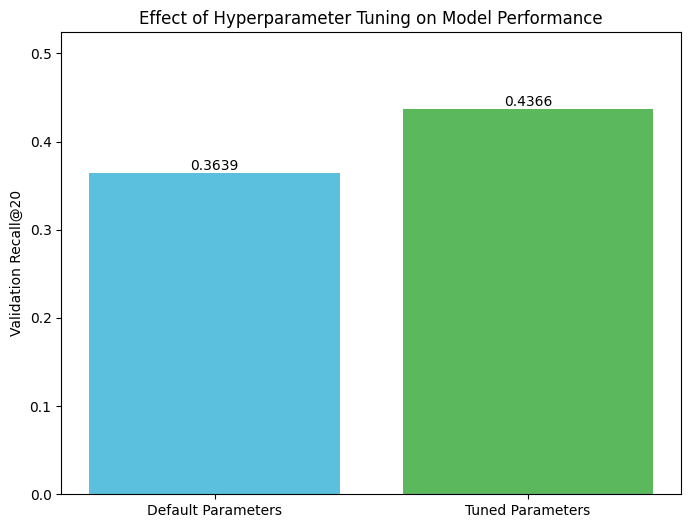

In [10]:
# --- STEP 5a: HYPERPARAMETER TUNING FOR HYBRID GRU4REC (ENHANCED VERSION) ---
# This process will test more settings to find the best possible model.

def evaluate_hybrid_model(model, val_df, k=20):
    """
    This function evaluates the performance of a GRU4Rec model on the validation dataset.
    It calculates the Recall@20 metric: the proportion of correct next items
    that the model successfully predicted within its top 20 recommendations.
    """
    model.eval() # Switch the model to evaluation mode (no learning).
    recalls = []
    # Prepare the validation data session by session.
    session_groups = val_df.groupby('session_id')
    val_sessions = [(group['item_idx'].tolist(), group['category_idx'].tolist()) for name, group in session_groups]
    
    with torch.no_grad(): # Disable gradient calculations to speed up predictions.
        for item_seq, cat_seq in val_sessions:
            if len(item_seq) < 2: continue
            # Prepare the input (items seen) and the target (the correct next item).
            item_input = torch.LongTensor([item_seq[:-1][-10:]]).to(device)
            cat_input = torch.LongTensor([cat_seq[:-1][-10:]]).to(device)
            target = item_seq[-1]
            
            logits = model(item_input, cat_input) # Get predictions from the model.
            topk = logits.cpu().numpy().argsort()[0][-k:][::-1] # Get the top K recommendations.
            
            if target in topk: # If the prediction is correct
                recalls.append(1)
            else: # If the prediction is incorrect
                recalls.append(0)
    # Return the average recall score.
    return np.mean(recalls) if recalls else 0

# --- Expand the hyperparameter search space ---
# We will test more values to have a better chance of finding the optimal result.
param_grid = {
    'lr': [0.001, 0.005, 0.01],
    'hid_dim': [100, 150, 200],
    'item_emb_dim': [50, 100],
    'cat_emb_dim': [10, 20]
}

best_recall = -1
best_params = {}
train_loader_gru = DataLoader(HybridSessionDataset(train), batch_size=256, shuffle=True)
loss_fn_for_tuning = nn.CrossEntropyLoss()

print("--- Starting Hyperparameter Tuning for Hybrid GRU4Rec (Enhanced) ---")

# Loop through all combinations of hyperparameters.
for lr in param_grid['lr']:
    for hid_dim in param_grid['hid_dim']:
        for item_emb in param_grid['item_emb_dim']:
            for cat_emb in param_grid['cat_emb_dim']:
                
                params = {'lr': lr, 'hid_dim': hid_dim, 'item_emb_dim': item_emb, 'cat_emb_dim': cat_emb}
                print(f"--- Testing with: {params} ---")
                
                # Create a new model with the current parameter set.
                current_model = HybridGRU4Rec(n_items, n_cats, 
                                              item_emb_dim=item_emb, 
                                              cat_emb_dim=cat_emb, 
                                              hid_dim=hid_dim).to(device)
                optimizer = torch.optim.Adam(current_model.parameters(), lr=lr)
                
                # --- Implement simple Early Stopping ---
                patience = 2 # Number of epochs to wait for improvement
                epochs_no_improve = 0
                best_epoch_recall = -1

                # Train for a maximum of 5 epochs, but can stop early.
                for epoch in range(5):
                    current_model.train()
                    for item_xb, cat_xb, yb in train_loader_gru:
                        item_xb, cat_xb, yb = item_xb.to(device), cat_xb.to(device), yb.to(device).squeeze()
                        optimizer.zero_grad()
                        logits = current_model(item_xb, cat_xb)
                        loss = loss_fn_for_tuning(logits, yb)
                        loss.backward()
                        optimizer.step()
                    
                    # Evaluate on the validation set after each epoch.
                    current_recall = evaluate_hybrid_model(current_model, valid)
                    print(f"Epoch {epoch+1}, Validation Recall@20: {current_recall:.4f}")
                    
                    if current_recall > best_epoch_recall:
                        best_epoch_recall = current_recall
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1
                    
                    if epochs_no_improve >= patience:
                        print(f"Early stopping at epoch {epoch+1} due to no improvement.")
                        break

                # Compare the best performance of this parameter set with the global best.
                if best_epoch_recall > best_recall:
                    best_recall = best_epoch_recall
                    best_params = params
                    best_params['recall'] = best_recall

print(f"\n--- Tuning Complete ---")
print(f"Best Params Found: {best_params}")

# --- Visualizing the Effect of Tuning ---
# To clearly see the difference, we compare the performance of the model with the best parameters
# against a model with default parameters.

# Create and train a model with default parameters (lr=0.001, hid_dim=100)
default_model_gru = HybridGRU4Rec(n_items, n_cats).to(device)
default_optimizer = torch.optim.Adam(default_model_gru.parameters(), lr=0.001)
for epoch in range(2): # Train the default model for 2 epochs for a fair comparison
    for item_xb, cat_xb, yb in train_loader_gru:
        item_xb, cat_xb, yb = item_xb.to(device), cat_xb.to(device), yb.to(device).squeeze()
        default_optimizer.zero_grad()
        logits = default_model_gru(item_xb, cat_xb)
        loss = loss_fn_for_tuning(logits, yb)
        loss.backward()
        default_optimizer.step()

# Get the performance of both models
default_recall = evaluate_hybrid_model(default_model_gru, valid)
tuned_recall = best_params.get('recall', 0)

# Plot a bar chart for comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(['Default Parameters', 'Tuned Parameters'], [default_recall, tuned_recall], color=['#5bc0de', '#5cb85c'])
plt.ylabel('Validation Recall@20')
plt.title('Effect of Hyperparameter Tuning on Model Performance')
plt.ylim(0, max(default_recall, tuned_recall) * 1.2) # Set y-axis limit for better visibility
# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')
plt.show()

#### 5b. Final Hybrid GRU4Rec Model Training

In [14]:
final_params = best_params if best_params else {'lr': 0.001, 'hid_dim': 100}

hybrid_gru_model = HybridGRU4Rec(
    n_items, 
    n_cats,
    hid_dim=final_params['hid_dim']
).to(device)
optimizer = torch.optim.Adam(hybrid_gru_model.parameters(), lr=final_params['lr'])
loss_fn = nn.CrossEntropyLoss()

print("\n--- Training Final Hybrid GRU4Rec Model ---")
for epoch in range(30):
    hybrid_gru_model.train()
    epoch_loss = 0
    for item_xb, cat_xb, yb in train_loader_gru:
        item_xb, cat_xb, yb = item_xb.to(device), cat_xb.to(device), yb.to(device).squeeze()
        optimizer.zero_grad()
        logits = hybrid_gru_model(item_xb, cat_xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader_gru):.4f}")


--- Training Final Hybrid GRU4Rec Model ---
Epoch 1, Loss: 8.1712
Epoch 2, Loss: 5.7481
Epoch 3, Loss: 4.7757
Epoch 4, Loss: 4.1805
Epoch 5, Loss: 3.7482
Epoch 6, Loss: 3.4076
Epoch 7, Loss: 3.1308
Epoch 8, Loss: 2.8982
Epoch 9, Loss: 2.7000
Epoch 10, Loss: 2.5274
Epoch 11, Loss: 2.3764
Epoch 12, Loss: 2.2453
Epoch 13, Loss: 2.1267
Epoch 14, Loss: 2.0208
Epoch 15, Loss: 1.9302
Epoch 16, Loss: 1.8472
Epoch 17, Loss: 1.7718
Epoch 18, Loss: 1.7052
Epoch 19, Loss: 1.6448
Epoch 20, Loss: 1.5935
Epoch 21, Loss: 1.5398
Epoch 22, Loss: 1.4958
Epoch 23, Loss: 1.4563
Epoch 24, Loss: 1.4157
Epoch 25, Loss: 1.3824
Epoch 26, Loss: 1.3515
Epoch 27, Loss: 1.3184
Epoch 28, Loss: 1.2954
Epoch 29, Loss: 1.2671
Epoch 30, Loss: 1.2415


## 6. Model Performance Comparison Table

In [16]:
# --- Evaluation Functions (More Robust Version) ---
def precision_at_k(y_true, y_pred, k=20):
    hits = 0
    total = 0
    for pred_list, true_item in zip(y_pred, y_true):
        # Ensure pred_list is a list and handle potential errors
        if not isinstance(pred_list, (list, np.ndarray)):
            continue # Skip if the prediction is not a list
        # Use a set for faster lookups
        if true_item in set(pred_list[:k]):
            hits += 1
        total += 1
    return hits / total if total > 0 else 0

def recall_at_k(y_true, y_pred, k=20):
    return precision_at_k(y_true, y_pred, k)

def ndcg_at_k(y_true, y_pred, k=20):
    ndcg = 0
    total = 0
    for pred_list, true_item in zip(y_pred, y_true):
        if not isinstance(pred_list, (list, np.ndarray)):
            continue
        total += 1
        try:
            idx = list(pred_list[:k]).index(true_item)
            ndcg += 1 / np.log2(idx + 2)
        except ValueError:
            continue # Item not in the top K, so its contribution is 0
    return ndcg / total if total > 0 else 0

# --- Prediction Functions ---
def predict_next_hybrid_gru(model, item_session, cat_session, k=20):
    model.eval()
    with torch.no_grad():
        item_inp = torch.LongTensor([item_session[-10:]]).to(device)
        cat_inp = torch.LongTensor([cat_session[-10:]]).to(device)
        logits = model(item_inp, cat_inp)
        topk = logits.cpu().numpy().argsort()[0][-k:][::-1]
    return topk.tolist()

# --- Prepare test data ---
test_sessions_df = test.groupby('session_id').agg(item_idxs=('item_idx', list), cat_idxs=('category_idx', list), user_idx=('user_idx', 'first')).reset_index()
test_sessions_df = test_sessions_df[test_sessions_df['item_idxs'].apply(len) > 1]
y_true = test_sessions_df['item_idxs'].apply(lambda x: x[-1]).tolist()

# Predictions from Most Popular
y_pred_pop = [most_popular for _ in y_true]

# Predictions from SVD
y_pred_svd = []
if svd_model is not None:
    all_item_idxs = train['item_idx'].unique()
    test_user_idxs = test_sessions_df['user_idx'].unique()
    svd_user2pred = {}
    for user_idx in test_user_idxs:
        interacted_items = train[train['user_idx'] == user_idx]['item_idx'].unique()
        items_to_predict = np.setdiff1d(all_item_idxs, interacted_items)
        predictions = [svd_model.predict(user_idx, item_idx) for item_idx in items_to_predict]
        predictions.sort(key=lambda x: x.est, reverse=True)
        svd_user2pred[user_idx] = [pred.iid for pred in predictions[:20]]
    y_pred_svd = [svd_user2pred.get(uidx, most_popular) for uidx in test_sessions_df['user_idx']]

# Predictions from Hybrid GRU4Rec
y_pred_gru_hybrid = []
for _, row in test_sessions_df.iterrows():
    item_input = row['item_idxs'][:-1]
    cat_input = row['cat_idxs'][:-1]
    pred = predict_next_hybrid_gru(hybrid_gru_model, item_input, cat_input, k=20)
    y_pred_gru_hybrid.append(pred)

# --- Create results table ---
results = []
results.append(['Most Popular', precision_at_k(y_true, y_pred_pop, 20), recall_at_k(y_true, y_pred_pop, 20), ndcg_at_k(y_true, y_pred_pop, 20)])
if svd_model:
    results.append(['SVD (Surprise)', precision_at_k(y_true, y_pred_svd, 20), recall_at_k(y_true, y_pred_svd, 20), ndcg_at_k(y_true, y_pred_svd, 20)])
if hybrid_gru_model:
    results.append(['Hybrid GRU4Rec (Tuned)', precision_at_k(y_true, y_pred_gru_hybrid, 20), recall_at_k(y_true, y_pred_gru_hybrid, 20), ndcg_at_k(y_true, y_pred_gru_hybrid, 20)])

results_df = pd.DataFrame(results, columns=['Model', 'Precision@20', 'Recall@20', 'NDCG@20'])
display(results_df)

,Model,Precision@20,Recall@20,NDCG@20
0,Most Popular,0.017294,0.017294,0.008429
1,SVD (Surprise),0.001424,0.001424,0.000335
2,Hybrid GRU4Rec (Tuned),0.281587,0.281587,0.166152


## 7. User-Friendly Demo

In [19]:
# Get a random session from the test set for the demo
test_sessions_df_demo = test.groupby('session_id').agg(
    item_ids_orig=('itemid', list), 
    item_idxs=('item_idx', list), 
    cat_idxs=('category_idx', list)
).reset_index()

valid_sessions = test_sessions_df_demo[test_sessions_df_demo['item_idxs'].apply(lambda x: len(x) >= 4)]
random_row = valid_sessions.sample(n=1, random_state=42)

# Prepare demo data
input_items_idx = random_row['item_idxs'].iloc[0][:-1]
input_cats_idx = random_row['cat_idxs'].iloc[0][:-1]
ground_truth_idx = random_row['item_idxs'].iloc[0][-1]

input_items_orig = item_enc.inverse_transform(input_items_idx)
ground_truth_orig = item_enc.inverse_transform([ground_truth_idx])[0]
user_display_id = random_row['session_id'].iloc[0].split('_')[0]


print(f"\n👤 User {user_display_id}'s recent items: ", ', '.join(map(str, input_items_orig)))
print(f"✅ Actual next item (ground truth): {ground_truth_orig}\n")

# --- Hybrid GRU4Rec Recommendations ---
print(f"Top 5 Recommendations (Hybrid GRU4Rec):")

# Define the recommendation function if it's not globally available
def recommend_hybrid_gru_with_probs(model, item_session, cat_session, n=5):
    model.eval()
    with torch.no_grad():
        item_inp = torch.LongTensor([item_session[-10:]]).to(device)
        cat_inp = torch.LongTensor([cat_session[-10:]]).to(device)
        logits = model(item_inp, cat_inp)
        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
        top_idx = np.argsort(probs)[::-1][:n]
        top_items = item_enc.inverse_transform(top_idx)
    return list(zip(top_items, probs[top_idx]))

# Get and print recommendations
for item, score in recommend_hybrid_gru_with_probs(hybrid_gru_model, input_items_idx, input_cats_idx, n=5):
    print(f"Item {item}, Probability={score:.4f}")


👤 User 1318877's recent items:  49635, 49635, 56640, 138672, 49635
✅ Actual next item (ground truth): 49635

Top 5 Recommendations (Hybrid GRU4Rec):
Item 95448, Probability=0.4312
Item 429101, Probability=0.0893
Item 8426, Probability=0.0709
Item 353221, Probability=0.0535
Item 412390, Probability=0.0500
